# Baseline Modeling and Feature Engineering

Notebook to explore the unsecured loan dataset, build feature engineering, and train baseline CatBoost, XGBoost, and LightGBM models with ROC AUC evaluation.


In [650]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [651]:
pip install xgboost 


Note: you may need to restart the kernel to use updated packages.


In [652]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [653]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [654]:
import os
import subprocess

try:
    gpu_check = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    USE_GPU = gpu_check.returncode == 0
except FileNotFoundError:
    USE_GPU = False

print(f"GPU available: {USE_GPU}")


GPU available: True


Enable GPU in Kaggle notebook settings (Runtime ➝ Change runtime type ➝ T4 GPU) for faster CatBoost/XGBoost/LightGBM training. The code auto-detects the GPU and switches booster backends accordingly.


In [655]:
train = pd.read_csv("/kaggle/input/triantestorg/train.csv")
test = pd.read_csv("/kaggle/input/triantestorg/test.csv")
sample_submission = pd.read_csv('/kaggle/input/sample-submission/sample_submission.csv')
train.shape, test.shape


((80000, 31), (20000, 30))

In [656]:
train['JIS Address Code'] = train['JIS Address Code'].fillna(-999).astype(int)
test['JIS Address Code'] = test['JIS Address Code'].fillna(-999).astype(int)


In [657]:
# Date & Time Engineering
train['Application Date'] = pd.to_datetime(train['Application Date'])
train['Date of Birth'] = pd.to_datetime(train['Date of Birth'])
test['Application Date'] = pd.to_datetime(test['Application Date'])
test['Date of Birth'] = pd.to_datetime(test['Date of Birth'])

# Age at application (HUGE feature)
train['Age'] = (train['Application Date'] - train['Date of Birth']).dt.days / 365.25
test['Age'] = (test['Application Date'] - test['Date of Birth']).dt.days / 365.25

# Application timing features
train['Application_Month'] = train['Application Date'].dt.month
train['Application_DayOfWeek'] = train['Application Date'].dt.dayofweek
test['Application_Month'] = test['Application Date'].dt.month
test['Application_DayOfWeek'] = test['Application Date'].dt.dayofweek

# Application Hour
train['Application_Hour'] = train['Application Time'] // 10000
test['Application_Hour'] = test['Application Time'] // 10000

print("✅ Date/Time features created")


✅ Date/Time features created


In [658]:
# Financial Ratio Engineering
epsilon = 1e-6

# Loan to income ratio
train['LOAN_TO_INCOME_RATIO'] = train['Application Limit Amount(Desired)'] / (train['Total Annual Income'] + epsilon)
test['LOAN_TO_INCOME_RATIO'] = test['Application Limit Amount(Desired)'] / (test['Total Annual Income'] + epsilon)

# Debt to income ratios
train['DECLARED_DEBT_TO_INCOME_RATIO'] = train['Declared Amount of Unsecured Loans'] / (train['Total Annual Income'] + epsilon)
test['DECLARED_DEBT_TO_INCOME_RATIO'] = test['Declared Amount of Unsecured Loans'] / (test['Total Annual Income'] + epsilon)

train['ACTUAL_DEBT_TO_INCOME_RATIO'] = train['Amount of Unsecured Loans'] / (train['Total Annual Income'] + epsilon)
test['ACTUAL_DEBT_TO_INCOME_RATIO'] = test['Amount of Unsecured Loans'] / (test['Total Annual Income'] + epsilon)

# Monthly debt to income (more accurate)
train['MONTHLY_INCOME'] = train['Total Annual Income'] / 12
test['MONTHLY_INCOME'] = test['Total Annual Income'] / 12

train['MONTHLY_DEBT_TO_INCOME'] = train['Amount of Unsecured Loans'] / (train['MONTHLY_INCOME'] + epsilon)
test['MONTHLY_DEBT_TO_INCOME'] = test['Amount of Unsecured Loans'] / (test['MONTHLY_INCOME'] + epsilon)

# Did they lie? (GIGANTIC red flag)
train['DEBT_DISCREPANCY_AMOUNT'] = train['Amount of Unsecured Loans'] - train['Declared Amount of Unsecured Loans']
test['DEBT_DISCREPANCY_AMOUNT'] = test['Amount of Unsecured Loans'] - test['Declared Amount of Unsecured Loans']

train['DEBT_DISCREPANCY_COUNT'] = train['Number of Unsecured Loans'] - train['Declared Number of Unsecured Loans']
test['DEBT_DISCREPANCY_COUNT'] = test['Number of Unsecured Loans'] - test['Declared Number of Unsecured Loans']

train['DEBT_DISCREPANCY_RATIO'] = train['DEBT_DISCREPANCY_AMOUNT'] / (train['Declared Amount of Unsecured Loans'] + epsilon)
test['DEBT_DISCREPANCY_RATIO'] = test['DEBT_DISCREPANCY_AMOUNT'] / (test['Declared Amount of Unsecured Loans'] + epsilon)

# Income per person
train['DEPENDENTS_TOTAL'] = train['Number of Dependents'] + train['Number of Dependent Children']
test['DEPENDENTS_TOTAL'] = test['Number of Dependents'] + test['Number of Dependent Children']

train['INCOME_PER_DEPENDENT'] = train['Total Annual Income'] / (train['DEPENDENTS_TOTAL'] + 1)
test['INCOME_PER_DEPENDENT'] = test['Total Annual Income'] / (test['DEPENDENTS_TOTAL'] + 1)

train['INCOME_PER_CHILD'] = train['Total Annual Income'] / (train['Number of Dependent Children'] + 1)
test['INCOME_PER_CHILD'] = test['Total Annual Income'] / (test['Number of Dependent Children'] + 1)

# Average loan amount
train['AVG_LOAN_AMOUNT_ACTUAL'] = train['Amount of Unsecured Loans'] / (train['Number of Unsecured Loans'] + epsilon)
test['AVG_LOAN_AMOUNT_ACTUAL'] = test['Amount of Unsecured Loans'] / (test['Number of Unsecured Loans'] + epsilon)

# Declared vs actual loan count ratio
train['LOAN_COUNT_RATIO'] = train['Number of Unsecured Loans'] / (train['Declared Number of Unsecured Loans'] + epsilon)
test['LOAN_COUNT_RATIO'] = test['Number of Unsecured Loans'] / (test['Declared Number of Unsecured Loans'] + epsilon)

# Rent to income ratio (monthly)
train['RENT_TO_MONTHLY_INCOME'] = train['Rent Burden Amount'] / (train['MONTHLY_INCOME'] + epsilon)
test['RENT_TO_MONTHLY_INCOME'] = test['Rent Burden Amount'] / (test['MONTHLY_INCOME'] + epsilon)

# Total monthly burden
train['TOTAL_MONTHLY_BURDEN'] = train['Rent Burden Amount'] + (train['Amount of Unsecured Loans'] / 12)
test['TOTAL_MONTHLY_BURDEN'] = test['Rent Burden Amount'] + (test['Amount of Unsecured Loans'] / 12)

train['TOTAL_BURDEN_TO_INCOME'] = train['TOTAL_MONTHLY_BURDEN'] / (train['MONTHLY_INCOME'] + epsilon)
test['TOTAL_BURDEN_TO_INCOME'] = test['TOTAL_MONTHLY_BURDEN'] / (test['MONTHLY_INCOME'] + epsilon)

print("✅ Financial ratio features created")


✅ Financial ratio features created


In [659]:
# Keep only essential stability features (remove noise)

# Employment stability
train['EMPLOYMENT_DURATION_YEARS'] = train['Duration of Employment at Company (Months)'] / 12
test['EMPLOYMENT_DURATION_YEARS'] = test['Duration of Employment at Company (Months)'] / 12

train['EMPLOYMENT_STABILITY'] = train['EMPLOYMENT_DURATION_YEARS'] / (train['Age'] + epsilon)
test['EMPLOYMENT_STABILITY'] = test['EMPLOYMENT_DURATION_YEARS'] / (test['Age'] + epsilon)

# Age buckets (keep as categorical)
train['AGE_BUCKET'] = pd.cut(train['Age'], bins=[0, 25, 35, 45, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)
test['AGE_BUCKET'] = pd.cut(test['Age'], bins=[0, 25, 35, 45, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)

print("✅ Simplified stability features created (removed frequency encoding noise)")


✅ Simplified stability features created (removed frequency encoding noise)


In [660]:
# Phase 6: Advanced Interaction Features

# 1. Stability Profile
train['STABILITY_RATIO'] = train['Duration of Employment at Company (Months)'] / (train['Age'] * 12 + epsilon)
test['STABILITY_RATIO'] = test['Duration of Employment at Company (Months)'] / (test['Age'] * 12 + epsilon)

# 2. Financial Burden Profile
train['RENT_BURDEN_PER_PERSON'] = train['Rent Burden Amount'] / (train['INCOME_PER_DEPENDENT'] + epsilon)
test['RENT_BURDEN_PER_PERSON'] = test['Rent Burden Amount'] / (test['INCOME_PER_DEPENDENT'] + epsilon)

# 3. Income vs Age
train['INCOME_PER_AGE'] = train['Total Annual Income'] / (train['Age'] + epsilon)
test['INCOME_PER_AGE'] = test['Total Annual Income'] / (test['Age'] + epsilon)

# 4. Total Financial Weight
train['TOTAL_FINANCIAL_BURDEN_RATIO'] = (train['Rent Burden Amount'] + train['Amount of Unsecured Loans']) / (train['Total Annual Income'] + epsilon)
test['TOTAL_FINANCIAL_BURDEN_RATIO'] = (test['Rent Burden Amount'] + test['Amount of Unsecured Loans']) / (test['Total Annual Income'] + epsilon)

# 5. Loan Ambition
train['AMBITION_RATIO'] = train['Application Limit Amount(Desired)'] / (train['Amount of Unsecured Loans'] + epsilon)
test['AMBITION_RATIO'] = test['Application Limit Amount(Desired)'] / (test['Amount of Unsecured Loans'] + epsilon)

print("✅ Advanced interaction features created")


✅ Advanced interaction features created


In [661]:
# Phase 7: Relative Income Trick (Group Aggregation)

print("Starting Group Aggregation features...")

group_cols = ['Industry Type', 'Employment Type', 'JIS Address Code', 'Company Size Category']
agg_cols = ['Total Annual Income', 'Age', 'LOAN_TO_INCOME_RATIO']

for group_col in group_cols:
    for agg_col in agg_cols:
        # Calculate stats on train only
        stats = train.groupby(group_col)[agg_col].agg(['mean', 'max', 'min']).reset_index()
        
        # Rename columns after aggregation
        stats.columns = [group_col, 'mean', 'max', 'min']
        
        # Merge to train
        train = train.merge(stats, on=group_col, how='left', suffixes=('', '_agg'))
        
        # Create relative feature (THE GOLD)
        train[f'{agg_col}_RELATIVE_to_{group_col}'] = train[agg_col] / (train['mean'] + epsilon)
        
        # Merge to test
        test = test.merge(stats, on=group_col, how='left', suffixes=('', '_agg'))
        test[f'{agg_col}_RELATIVE_to_{group_col}'] = test[agg_col] / (test['mean'] + epsilon)
        
        # Clean up
        train = train.drop(columns=['mean', 'max', 'min'])
        test = test.drop(columns=['mean', 'max', 'min'])

print("✅ Group Aggregation features created")


Starting Group Aggregation features...
✅ Group Aggregation features created


In [662]:
# STRONGER financial features - make them impossible to ignore

# 1. Debt liar flag (strong signal - categorical)
train['DEBT_LIAR_FLAG'] = ((train['DEBT_DISCREPANCY_AMOUNT'] > 100000) | 
                            (train['DEBT_DISCREPANCY_COUNT'] > 1)).astype(int)
test['DEBT_LIAR_FLAG'] = ((test['DEBT_DISCREPANCY_AMOUNT'] > 100000) | 
                           (test['DEBT_DISCREPANCY_COUNT'] > 1)).astype(int)

# 2. High debt × multiple loans (interaction - very risky combo)
train['HIGH_DEBT_MULTI_LOAN'] = ((train['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.3) & 
                                   (train['Number of Unsecured Loans'] > 2)).astype(int)
test['HIGH_DEBT_MULTI_LOAN'] = ((test['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.3) & 
                                  (test['Number of Unsecured Loans'] > 2)).astype(int)

# 3. ULTRA-STRONG Financial risk score (combine ALL debt signals)
train['FIN_RISK_SCORE'] = (
    train['ACTUAL_DEBT_TO_INCOME_RATIO'] * 0.35 +
    train['LOAN_TO_INCOME_RATIO'] * 0.25 +
    train['DECLARED_DEBT_TO_INCOME_RATIO'] * 0.15 +
    (train['Number of Unsecured Loans'] / 5) * 0.15 +
    (np.abs(train['DEBT_DISCREPANCY_AMOUNT']) / (train['Total Annual Income'] + epsilon)).clip(0, 1) * 0.1
).clip(0, 10)
test['FIN_RISK_SCORE'] = (
    test['ACTUAL_DEBT_TO_INCOME_RATIO'] * 0.35 +
    test['LOAN_TO_INCOME_RATIO'] * 0.25 +
    test['DECLARED_DEBT_TO_INCOME_RATIO'] * 0.15 +
    (test['Number of Unsecured Loans'] / 5) * 0.15 +
    (np.abs(test['DEBT_DISCREPANCY_AMOUNT']) / (test['Total Annual Income'] + epsilon)).clip(0, 1) * 0.1
).clip(0, 10)

# Keep old one for compatibility
train['FIN_STRESS_COMPOSITE'] = train['FIN_RISK_SCORE']
test['FIN_STRESS_COMPOSITE'] = test['FIN_RISK_SCORE']

# 4. Debt × Employment interaction (employment is #1, debt is #7 - combine them!)
train['DEBT_X_EMP_DURATION'] = train['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(train['Duration of Employment at Company (Months)'])
test['DEBT_X_EMP_DURATION'] = test['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(test['Duration of Employment at Company (Months)'])

# 5. NEW: Debt × Loan Count (both are top features - combine!)
train['DEBT_X_LOAN_COUNT'] = train['ACTUAL_DEBT_TO_INCOME_RATIO'] * train['Number of Unsecured Loans']
test['DEBT_X_LOAN_COUNT'] = test['ACTUAL_DEBT_TO_INCOME_RATIO'] * test['Number of Unsecured Loans']

# 5b. Debt × AVG Loan Amount (combine #7 and #13 features)
train['DEBT_X_AVG_LOAN'] = train['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(train['AVG_LOAN_AMOUNT_ACTUAL'])
test['DEBT_X_AVG_LOAN'] = test['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(test['AVG_LOAN_AMOUNT_ACTUAL'])

# 6. NEW: High risk flag (multiple red flags)
train['MULTI_RISK_FLAG'] = (
    (train['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) +
    (train['Number of Unsecured Loans'] > 3).astype(int) +
    (train['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int)
).clip(0, 3)
test['MULTI_RISK_FLAG'] = (
    (test['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) +
    (test['Number of Unsecured Loans'] > 3).astype(int) +
    (test['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int)
).clip(0, 3)

print("✅ Stronger financial features created")


✅ Stronger financial features created


In [663]:
# Risk segmentation & binning
train['INCOME_BRACKET'] = pd.qcut(train['Total Annual Income'], q=10, labels=False, duplicates='drop').astype(int)
test['INCOME_BRACKET'] = pd.qcut(test['Total Annual Income'], q=10, labels=False, duplicates='drop').astype(int)

train['DEBT_BRACKET'] = pd.qcut(train['Amount of Unsecured Loans'].replace(0, np.nan), q=5, labels=False, duplicates='drop').fillna(0).astype(int)
test['DEBT_BRACKET'] = pd.qcut(test['Amount of Unsecured Loans'].replace(0, np.nan), q=5, labels=False, duplicates='drop').fillna(0).astype(int)

# Multi-risk composite score
train['COMPOSITE_RISK'] = (
    (train['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) * 3 +
    (train['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int) * 2 +
    (train['Number of Unsecured Loans'] > 3).astype(int) * 2 +
    (train['Age'] < 25).astype(int) * 1 +
    (train['EMPLOYMENT_DURATION_YEARS'] < 1).astype(int) * 1
)
test['COMPOSITE_RISK'] = (
    (test['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) * 3 +
    (test['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int) * 2 +
    (test['Number of Unsecured Loans'] > 3).astype(int) * 2 +
    (test['Age'] < 25).astype(int) * 1 +
    (test['EMPLOYMENT_DURATION_YEARS'] < 1).astype(int) * 1
)

# Income vs loan combinations (using log transform)
train['INCOME_LOAN_PRODUCT'] = np.log1p(train['Total Annual Income']) * np.log1p(train['Amount of Unsecured Loans'])
test['INCOME_LOAN_PRODUCT'] = np.log1p(test['Total Annual Income']) * np.log1p(test['Amount of Unsecured Loans'])

print("✅ Risk segmentation completed")


✅ Risk segmentation completed


In [664]:
# Phase 8: Polynomials & Non-Linearity

print("Starting Non-Linear features...")

# Log transforms
train['Total_Annual_Income_log'] = np.log1p(train['Total Annual Income'])
test['Total_Annual_Income_log'] = np.log1p(test['Total Annual Income'])

train['Application_Limit_log'] = np.log1p(train['Application Limit Amount(Desired)'])
test['Application_Limit_log'] = np.log1p(test['Application Limit Amount(Desired)'])

train['Amount_Unsecured_Loans_log'] = np.log1p(train['Amount of Unsecured Loans'])
test['Amount_Unsecured_Loans_log'] = np.log1p(test['Amount of Unsecured Loans'])

# Polynomial features
train['Age_sq'] = train['Age']**2
test['Age_sq'] = test['Age']**2

train['Duration_Employment_sq'] = train['Duration of Employment at Company (Months)']**2
test['Duration_Employment_sq'] = test['Duration of Employment at Company (Months)']**2

print("✅ Non-Linear features created")


Starting Non-Linear features...
✅ Non-Linear features created


In [665]:
# Categorical features - add new risk flags
categorical_features = [
    'Major Media Code', 'Internet Details', 'Reception Type Category',
    'Gender', 'Single/Married Status',
    'Residence Type', 'Name Type', 'Family Composition Type',
    'Living Arrangement Type', 'Insurance Job Type', 'Employment Type',
    'Employment Status Type', 'Industry Type', 'Company Size Category',
    'Application_Month', 'Application_DayOfWeek', 'Application_Hour',
    'AGE_BUCKET', 'DEBT_LIAR_FLAG', 'HIGH_DEBT_MULTI_LOAN', 'MULTI_RISK_FLAG'
]

for col in categorical_features:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

print(f"Categorical features: {len(categorical_features)}")


Categorical features: 21


In [666]:
TARGET = 'Default 12 Flag'

# Balanced: Keep all features but strengthen financial ones
drop_cols = ['ID', TARGET, 'Application Date', 'Application Time', 'Date of Birth']

features = [col for col in train.columns if col not in drop_cols and col in train.columns]
# Filter out any columns that don't exist
features = [f for f in features if f in train.columns]

y = train[TARGET]
X = train[features]

print(f"Total features: {len(features)} (pruned from {len(train.columns)-1})")
print(f"Default rate: {y.mean()*100:.2f}%")
print(f"\nDropped overfitting features: {len(drop_cols)} columns")


Total features: 83 (pruned from 87)
Default rate: 9.91%

Dropped overfitting features: 5 columns


In [667]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [668]:
baseline_aucs = []
models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=3500,
        learning_rate=0.02,
        depth=7,
        l2_leaf_reg=6,
        eval_metric='AUC',
        cat_features=categorical_features,
        early_stopping_rounds=200,
        verbose=100,
        random_state=42,
        task_type='GPU',
        devices='0',
        one_hot_max_size=15,
        min_data_in_leaf=25,
        border_count=254,
        bootstrap_type='Bernoulli',
        subsample=0.75,
        boosting_type='Plain',
        scale_pos_weight=2.5
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    
    preds = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, preds)
    baseline_aucs.append(auc_score)
    models.append(model)
    print(f"Fold {fold+1} AUC: {auc_score:.6f}\n")

print(f"\n--- Tuned CatBoost CV AUC ---")
print(f"Mean AUC: {np.mean(baseline_aucs):.6f}")
print(f"Std AUC:  {np.std(baseline_aucs):.6f}")
print(f"Min AUC:  {np.min(baseline_aucs):.6f}")
print(f"Max AUC:  {np.max(baseline_aucs):.6f}")


--- Fold 1 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6286711	best: 0.6286711 (0)	total: 40ms	remaining: 2m 20s
100:	test: 0.6712019	best: 0.6712019 (100)	total: 2.29s	remaining: 1m 17s
200:	test: 0.6763508	best: 0.6763508 (200)	total: 4.43s	remaining: 1m 12s
300:	test: 0.6784698	best: 0.6784698 (300)	total: 6.58s	remaining: 1m 9s
400:	test: 0.6786225	best: 0.6786303 (399)	total: 8.72s	remaining: 1m 7s
500:	test: 0.6790033	best: 0.6790727 (488)	total: 10.9s	remaining: 1m 5s
600:	test: 0.6796033	best: 0.6797206 (583)	total: 13.1s	remaining: 1m 2s
700:	test: 0.6786480	best: 0.6797206 (583)	total: 15.2s	remaining: 1m
bestTest = 0.6797205806
bestIteration = 583
Shrink model to first 584 iterations.
Fold 1 AUC: 0.679721


--- Fold 2 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6219514	best: 0.6219514 (0)	total: 22.3ms	remaining: 1m 18s
100:	test: 0.6646722	best: 0.6646722 (100)	total: 2.16s	remaining: 1m 12s
200:	test: 0.6698229	best: 0.6700319 (198)	total: 4.33s	remaining: 1m 11s
300:	test: 0.6709636	best: 0.6711251 (296)	total: 6.48s	remaining: 1m 8s
400:	test: 0.6714554	best: 0.6718853 (387)	total: 8.61s	remaining: 1m 6s
500:	test: 0.6719020	best: 0.6720116 (461)	total: 10.7s	remaining: 1m 4s
600:	test: 0.6723532	best: 0.6724591 (583)	total: 12.9s	remaining: 1m 2s
700:	test: 0.6714633	best: 0.6724591 (583)	total: 15s	remaining: 59.8s
bestTest = 0.6724590957
bestIteration = 583
Shrink model to first 584 iterations.
Fold 2 AUC: 0.672459


--- Fold 3 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6288584	best: 0.6288584 (0)	total: 21.6ms	remaining: 1m 15s
100:	test: 0.6646904	best: 0.6646904 (100)	total: 2.17s	remaining: 1m 12s
200:	test: 0.6694512	best: 0.6694512 (200)	total: 4.32s	remaining: 1m 10s
300:	test: 0.6715444	best: 0.6716091 (293)	total: 6.41s	remaining: 1m 8s
400:	test: 0.6720422	best: 0.6721188 (356)	total: 8.5s	remaining: 1m 5s
500:	test: 0.6725604	best: 0.6727472 (472)	total: 10.6s	remaining: 1m 3s
600:	test: 0.6719196	best: 0.6727472 (472)	total: 12.7s	remaining: 1m 1s
bestTest = 0.672747165
bestIteration = 472
Shrink model to first 473 iterations.
Fold 3 AUC: 0.672747


--- Fold 4 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6152888	best: 0.6152888 (0)	total: 19.4ms	remaining: 1m 7s
100:	test: 0.6489625	best: 0.6489625 (100)	total: 2.18s	remaining: 1m 13s
200:	test: 0.6578734	best: 0.6578743 (199)	total: 4.29s	remaining: 1m 10s
300:	test: 0.6615189	best: 0.6615189 (300)	total: 6.36s	remaining: 1m 7s
400:	test: 0.6647883	best: 0.6647883 (400)	total: 8.45s	remaining: 1m 5s
500:	test: 0.6669526	best: 0.6669526 (500)	total: 10.6s	remaining: 1m 3s
600:	test: 0.6665331	best: 0.6672765 (522)	total: 12.7s	remaining: 1m 1s
700:	test: 0.6671658	best: 0.6676490 (673)	total: 14.8s	remaining: 59.1s
800:	test: 0.6672776	best: 0.6676490 (673)	total: 17s	remaining: 57.1s
bestTest = 0.6676490307
bestIteration = 673
Shrink model to first 674 iterations.
Fold 4 AUC: 0.667649


--- Fold 5 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6217700	best: 0.6217700 (0)	total: 26.9ms	remaining: 1m 34s
100:	test: 0.6656591	best: 0.6657515 (97)	total: 2.14s	remaining: 1m 12s
200:	test: 0.6707235	best: 0.6707737 (198)	total: 4.24s	remaining: 1m 9s
300:	test: 0.6729067	best: 0.6729159 (298)	total: 6.44s	remaining: 1m 8s
400:	test: 0.6743721	best: 0.6745041 (398)	total: 8.6s	remaining: 1m 6s
500:	test: 0.6750229	best: 0.6750229 (500)	total: 10.7s	remaining: 1m 4s
600:	test: 0.6745944	best: 0.6752499 (540)	total: 12.9s	remaining: 1m 2s
700:	test: 0.6744000	best: 0.6752499 (540)	total: 15.1s	remaining: 1m
bestTest = 0.6752499342
bestIteration = 540
Shrink model to first 541 iterations.
Fold 5 AUC: 0.675250


--- Tuned CatBoost CV AUC ---
Mean AUC: 0.673565
Std AUC:  0.003940
Min AUC:  0.667649
Max AUC:  0.679721


In [669]:
X_test = test[features]
test_preds = np.zeros(len(X_test))

for model in models:
    test_preds += model.predict_proba(X_test)[:, 1]

test_preds = test_preds / len(models)

submission = pd.DataFrame({
    'ID': test['ID'],
    'Default 12 Flag': test_preds
})

submission.to_csv('baseline_catboost_submission.csv', index=False)
print("Submission saved!")
submission.head()


Submission saved!


,ID,Default 12 Flag
0,202511080001,0.144981
1,202511080002,0.160467
2,202511080003,0.185681
3,202511080004,0.070466
4,202511080005,0.183804


Top 20 Features:
                                            Feature  Importance
18                            Company Size Category    3.552776
7                                  JIS Address Code    3.264079
23                        Number of Unsecured Loans    2.986021
14                               Insurance Job Type    2.752535
1                                  Internet Details    2.751023
11                   Duration of Residence (Months)    2.622880
4                             Single/Married Status    2.292484
17                                    Industry Type    2.268454
41                           AVG_LOAN_AMOUNT_ACTUAL    2.193098
27                                Application_Month    2.116779
55                    Age_RELATIVE_to_Industry Type    2.052042
61                 Age_RELATIVE_to_JIS Address Code    1.911045
58                  Age_RELATIVE_to_Employment Type    1.890396
81                                           Age_sq    1.827546
2                      

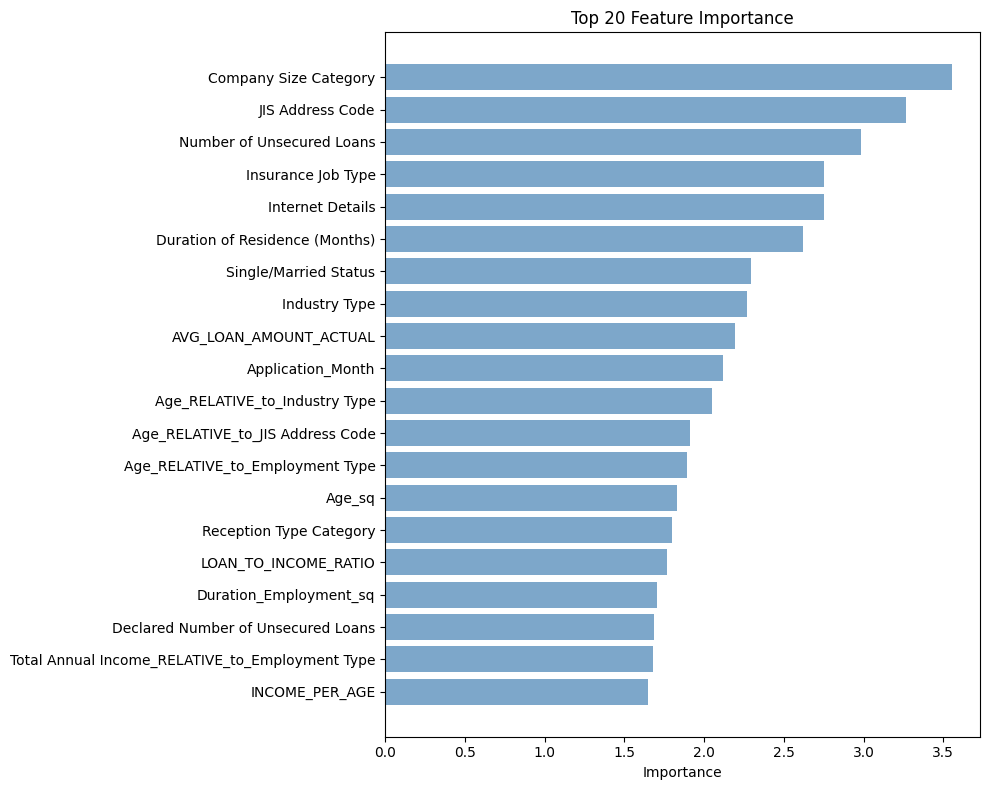

In [670]:
feature_importance = models[0].get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Features:")
print(importance_df.head(20))

plt.figure(figsize=(10, 8))
top20 = importance_df.head(20)
plt.barh(range(len(top20)), top20['Importance'].values, color='steelblue', alpha=0.7)
plt.yticks(range(len(top20)), top20['Feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
